# DeepWaveAccel simulation

### Load relevent libraries for DeepWaveAccel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

import Preprocess as pp
import Goertzel as g

### Load and preprocess dataset and training info

In [2]:
# Dataset
Df = pp.DataSet.from_file("/mnt/c/Users/bramh/Documents/UNI git/DeepWave/datasets/FRIDA/dataset/D_1-5_freq0_cold.npz") # proprocessed dataset from DeepWave
Pf = np.load("/mnt/c/Users/bramh/Documents/UNI git/DeepWave/datasets/FRIDA/dataset/D_freq0_train.npz") # trained model parameters

# Load the raw data (wave file)
wav_path = "/mnt/c/Users/bramh/Documents/UNI git/DeepWave/datasets/FRIDA/FRIDA/recordings/20160908/data_pyramic/segmented/two_speakers/1-5.wav"
fs, Draw = wav.read(wav_path)
ff = 1500 # Frequency of interest

# Preprocess the dataset
N_ch = Df.XYZ.shape[1] # number of microphones in the array data
N_px = Df.R.shape[1] # number of pixels in the intensity map
sampler = Df.sampler()


# Decode model parameters and print shapes
K = int(Pf['K']) # Chev filter polynomial order
N_layer = Pf['N_layer'] # number of layers
p_opt = Pf['p_opt'][np.argmin(Pf['v_loss'])]
param = pp.Parameter(48, 2234, 22)
K, B, tau = param.decode(p_opt)
print("Model parameters")
print("K shape: ", K.shape)
print("B shape: ", B.shape)
print("tau shape: ", tau.shape)

# # Plot the parameters
# plt.figure(figsize=(12, 8))
# plt.subplot(3, 1, 1)
# plt.plot(K, label='K')
# plt.title('K')
# plt.subplot(3, 1, 2)
# plt.plot(B[0, :], label='B')
# plt.title('B')
# plt.subplot(3, 1, 3)
# plt.plot(tau, label='tau')
# plt.title('tau')
# plt.tight_layout()
# plt.show()



Model parameters
K shape:  (23,)
B shape:  (48, 2234)
tau shape:  (2234,)


### Time-frequency domain conversion

Frequency of interest:  1500
Selected bin:  19
Frequency of this bin:  1520.0
Power of frequency bin:  [1.54118969e-02 8.51974141e-04 1.21579272e-02 5.98863327e-03
 6.89523574e-03 1.77092998e-03 4.74584608e-03 2.17362415e-03
 5.30336195e-03 4.99738439e-03 8.10251520e-03 4.74141787e-03
 4.62913430e-03 8.58140982e-03 8.84786295e-03 3.83309064e-03
 7.73744783e-03 1.13245691e-02 3.62394789e-03 9.39597264e-03
 2.29321700e-03 2.34082654e-02 5.34733407e-03 8.23499982e-03
 2.95923222e-02 3.21609152e-03 1.96410260e-03 3.72227577e-05
 3.25614011e-03 4.14822302e-05 2.40672840e-02 1.30602647e-03
 1.39248342e-02 1.57954688e-03 9.40036730e-04 8.15094988e-03
 2.88957035e-03 1.19138618e-02 4.91023485e-03 6.18357531e-03
 8.03127515e-05 1.27188800e-02 1.13205871e-03 1.77082239e-03
 1.56306990e-04 1.04375779e-02 2.34928919e-02 2.09446829e-03]


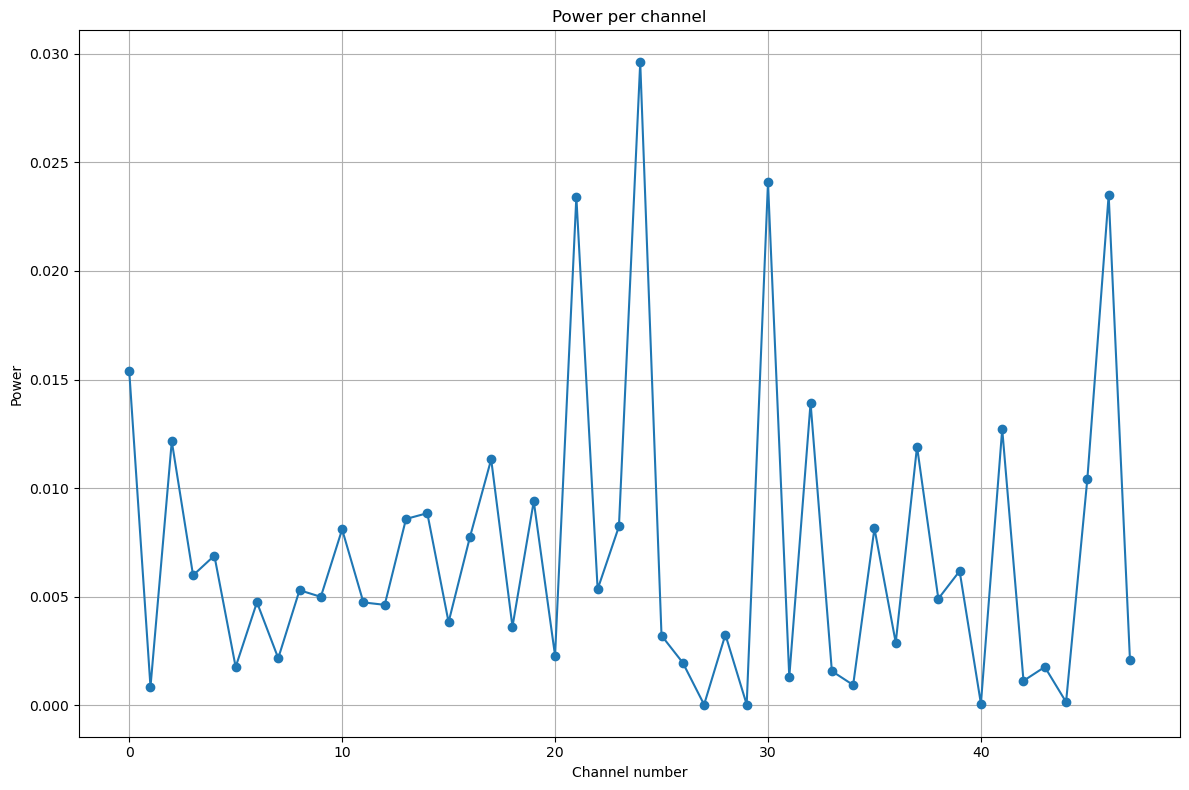

In [8]:
nf = 200 # Window size [samples]
fr = fs / nf # Frequency resolution per bin [Hz]
bin = round(ff / fr) # Bin number of the frequency of interest
factual = bin * fr # Frequency of the bin [Hz]
print("Frequency of interest: ", ff)
print("Selected bin: ", bin)
print("Frequency of this bin: ", factual)
res = g.goertzel(Draw, bin, nf)
# print("Goertzel result: ", res)
# Power of frequency bin
P = np.abs(res) ** 2
print("Power of frequency bin: ", P)

# Plot the power per channel
plt.figure(figsize=(12, 8))
plt.plot(np.arange(0, N_ch), P, 'o-')
plt.title('Power per channel')
plt.xlabel('Channel number')
plt.ylabel('Power')
plt.grid()
plt.tight_layout()
plt.show()

